In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score



#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Current working directory: /shared_folder/eas_508_project


In [2]:
pbp_path = 'data/interim/pbp/'

pbp_name = 'featured_11_13.csv'

df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})
shape = df.shape
columns = df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

df.head()

/tmp/ipykernel_89840/2280615120.py:5: DtypeWarning: Columns (84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})


✔✔✔ File Loaded

Shape: (307576, 114)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'yrdln', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'run_location', 'run_gap', 'score_differential', 'no_score_prob', 'fg_prob', 'td_prob', 'ep', 'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'field_goal_attempt', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 'season', 'order_sequence', 'stadium', 'weather', 'nfl_api_id', 'fixed_drive'

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa,yard_group,previous_success,home,spread
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,0to5,0.0,1,-3.0
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,0to5,1.0,1,-3.0
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,0to5,1.0,1,-3.0
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,5to10,0.0,1,-3.0
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042,0to5,1.0,1,-3.0


In [ ]:
# Useable Features
features = ['down',
            'ydstogo',
            'ydstosuccess',
            'yard_group',
            'yardline_100',
            'previous_success',
            'offense_formation',
            'defenders_in_box',
            'QB',
            'RB',
            'TE',
            'WR',
            'OL',
            'O_OTHER',
            'DL',
            'LB',
            'DB',
            'D_OTHER',
            'home',
            'score_differential',
            'spread',
            'total_line',
            'qtr',
            'quarter_seconds_remaining',
            'epa']

cat_features = ['yard_group',
                'offense_formation']

target = 'epa'

In [ ]:
model_df = df[features]
for col in cat_features:
    model_df[col] = model_df[col].astype(str)
    model_df[col] = LabelEncoder().fit_transform(model_df[col])
model_df = model_df.copy()

X = model_df.drop(columns=target)
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)

/tmp/ipykernel_89840/1708151020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = model_df[col].astype(str)
/tmp/ipykernel_89840/1708151020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = LabelEncoder().fit_transform(model_df[col])
/tmp/ipykernel_89840/1708151020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # for regression
    tree_method='hist',            # fastest on modern CPUs (and Apple Silicon)
    n_estimators=600,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)


RMSE:  1.350090576328431
R2:  -0.0012053711274426782


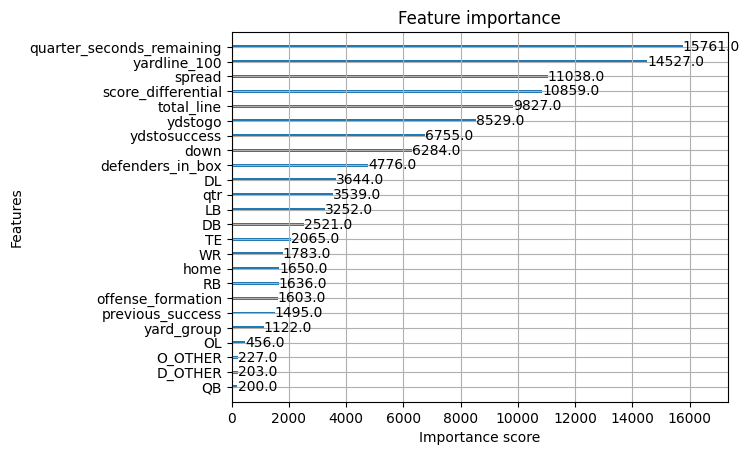

In [13]:
xgb.plot_importance(model)
plt.show()